## Constructing Zone 7 Load Profiles

*raw_csv* contains the following data: 
- Consumers Energy 2019 8760-hour load profile
- DTE 2018 8760-hour load profile
- DTW 2019 8760-hour load profile

Each file contains the load broken down by customer class and rate. 

My goal is to construct a 2019 8760-hour load profile for MISO Zone 7, whose shape we assume will be well-approximated by combining the 2019 Consumers Energy data with the 2019 DTE data, since these two utilities make up around 90% of the total load in zone 7. The rest is made up from many smaller utilities whose load profiles (we assume) will not dramatically affect the shape. We'll get the overall load for Zone 7 by scaling the 90% up to 100%. 

Later, we will use the 2018 and 2019 data from DTE to inform our construction of a load profile for Ann Arbor. This will be trickier, since the customer class breakdown for Ann Arbor will be different from DTE as a whole, since Ann Arbor is a unique town in its service territory. 

___

### Transforming DTE & Consumers load profiled by class into total load profiles

In [308]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [307]:
# helper functions
def make_timestamp(year, month, day, hour): 
    """
    Take the Month, Day, and Hour columns and express it as a single timestamp column. For example: 
    Month-4, Day-15, Hour-11 becomes 2019-04-15 10:00 (we are considering HE 11 to be stamped at 10am)
    """
    return datetime.strptime(f'{month}/{day}/{year} {hour - 1}', '%m/%d/%Y %H')

def hour_from_timestamp(timestamp): 
    """
    Given a Datetime object, returns the hour of the year (from 1 to 8760), i.e. 1/3/2019 00:00:00 --> 49
    """
    day = datetime.strftime(timestamp, '%j')
    hour = timestamp.hour + 1
    return (int(day) - 1) * 24 + hour

def convert_kwh_to_int(string): 
    """
    Converts the text from an element of the Kwh column to an integer
    """
    if '-' in string:
        return np.nan
    else: 
        return float(string.replace(',', ''))


In [405]:
# paths to raw csv files
ce_2019 = 'raw_csv/ce-2019-by-class.csv'
dte_2018 = 'raw_csv/dte-2018-by-class.csv'
dte_2019 = 'raw_csv/dte-2019-by-class.csv'

# pick current file
current_csv = dte_2019

In [406]:
# create df and timestamp column
df = pd.read_csv(current_csv)
df.insert(
    loc=0
    , column='Timestamp'
    , value=df.apply(lambda row: make_timestamp(2019, row['Month'], row['Day'], row['Hour']), axis=1)
)
df_has_been_transformed = False

In [418]:
# drop timestamp elements and create hour column mapping a timestamp to an hour from 1 to 8760
if not df_has_been_transformed: 
    df = df.drop(['Month', 'Day', 'Hour'], axis=1)
    if 'Year' in df.columns: 
        df = df.drop(['Year'], axis=1)
    df.insert(
        loc=1
        , column='Hour'
        , value=df.Timestamp.apply(hour_from_timestamp)
    )
    # convert kwh column into a usable integer
    if 'Kwh' in df.columns: 
        df.Kwh = df.Kwh.apply(convert_kwh_to_int)
        df = df.rename({'Kwh': 'CE 2019 kWh'}, axis=1)
    elif '2019 kwh' in df.columns: 
        df['2019 kwh'] = df['2019 kwh'].apply(convert_kwh_to_int)
        df = df.rename({'2019 kwh': 'DTE 2019 kWh'}, axis=1)
    df_has_been_transformed = True
df

,Timestamp,Hour,Class,Rate,DTE 2019 kWh
0,2019-01-01 00:00:00,1,RA-Residential,D1,34.36
1,2019-01-01 01:00:00,2,RA-Residential,D1,35.67
2,2019-01-01 02:00:00,3,RA-Residential,D1,31.71
3,2019-01-01 03:00:00,4,RA-Residential,D1,33.62
4,2019-01-01 04:00:00,5,RA-Residential,D1,31.15
...,...,...,...,...,...
486995,2019-12-31 19:00:00,8756,Secondary,RDG,169.03
486996,2019-12-31 20:00:00,8757,Secondary,RDG,172.34
486997,2019-12-31 21:00:00,8758,Secondary,RDG,171.72
486998,2019-12-31 22:00:00,8759,Secondary,RDG,171.38


In [371]:
# change column either to DTE 2019 kWh or CE 2019 kWh
grouped = df.groupby(by='Hour')[['DTE 2019 kWh']].sum()
grouped

,DTE 2019 kWh
Hour,
1,4295735.29
2,4158898.77
3,4038122.58
4,3955289.62
5,3921134.33
...,...
8756,5118314.14
8757,4972211.07
8758,4834341.66


In [372]:
if current_csv == ce_2019: 
    new_file = 'ce-2019-total.csv'
elif current_csv == dte_2019: 
    new_file = 'dte-2019-total.csv'
grouped.to_csv(f'zone-7-data/{new_file}')

### troubleshooting - DTE is missing 2019-03-10 02:00:00

DTE has no data for hour 1635 of the year, or 2019-03-10 02:00:00

To do: 
- &check; look for anomalously high load hour in DTE at DLS crossover in the fall
    - result: DTE is simply missing 1635, and doesn't make up for it by duplicating the DLS hour in the fall (around hour 7300-7400)
- &check; fill in missing hour either by interpolating, or by splitting an existing hour in half at the crossover
    - result: missing hour is filled in using linear interpolation 

### Constructing the total load profile for both DTE & Consumers

In [458]:
df_dte = pd.read_csv('zone-7-data/dte-2019-total.csv')
df_ce = pd.read_csv('zone-7-data/ce-2019-total.csv')

# fill in the missing hour for DTE
if len(df_dte.loc[df_dte['Hour'] == 1635]) == 0: 
    df_dte.loc[-1, 'Hour'] = 1635
    df_dte = df_dte.sort_values('Hour').reset_index(drop=True)
    df_dte = df_dte.interpolate()

df_zone_7 = pd.merge(df_dte, df_ce, how='inner')
df_zone_7['Sum 2019 kWh'] = df_zone_7['DTE 2019 kWh'] + df_zone_7['CE 2019 kWh']

ValueError: x and y must be the same size

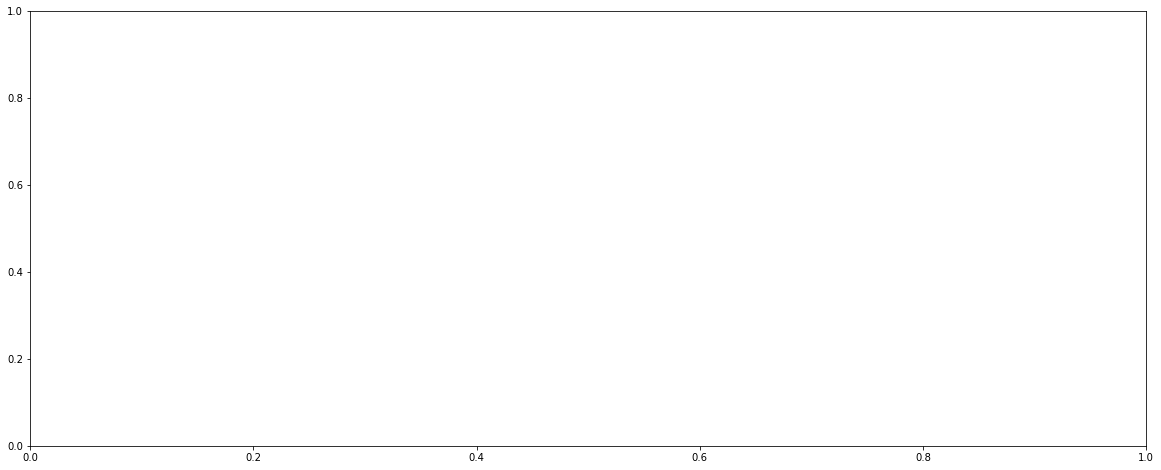

In [386]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
df_zone_7.plot(
    x='Hour'
    , y=['DTE 2019 kWh', 'CE 2019 kWh']
    , ax=ax
    , kind='scatter')
df_zone_7.plot()